In [1]:
"""
Copyright (c) 2017-2022 Yuhei Otsubo
Released under the MIT license
http://opensource.org/licenses/mit-license.php
"""

'\nCopyright (c) 2017-2022 Yuhei Otsubo\nReleased under the MIT license\nhttp://opensource.org/licenses/mit-license.php\n'

In [2]:
path = './dataset/20200424compiler/'
#block size
op_num = 235
block_size = op_num
args_s_limit = 1000
# K-split cross-validation
args_k = 4
# num of epochs
args_epoch = 50
args_batch_size = 64
args_arch_num = 9
args_max_norm = 0.001#0.25 #勾配クリッピング
args_gn_rate = 1.0 #Layer-wised Gradient Normalization
# for saving trained model
args_output_model = ''#'20220517_04compiler'
args_input_model = '20230104_01compiler'
args_img_filename = 'output/ex1_dft+'

# Automatic download of traind model when it is created (for Google Colab)
F_download = False#True
# Visualizing the output of the Weak Learner by T-SNE
F_arch_check = True
# Use multiple GPUs
F_multi_GPU = False#True
cuda_device = "cuda:1"

In [3]:
#for Google Colab
F_colab = False
if F_colab and 'Init_Flag' not in locals().keys():
  print('Initialization')
  #mount google drive
  from google.colab import drive
  from google.colab import files
  drive.mount('/content/drive')
  #download dataset
  !cp 'drive/My Drive/00_dataset/compiler/20200424compiler.zip' './dataset.zip'
  #!cp 'drive/My Drive/00_dataset/compiler/20200608compiler_old.zip' './dataset.zip'
  !unzip -o -qq dataset.zip

  Init_Flag = True
else:
  print('Initialization done')


Initialization done


In [4]:
import os
import random
import numpy as np
import math
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
#import secrets
from matplotlib.colors import Normalize
import itertools
import time
from sklearn.manifold import TSNE


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
args_output = ''


In [6]:
def fild_all_files(directory):
    for root, dirs, files in os.walk(directory):
        yield root
        for file in files:
            path = os.path.join(root, file)
            if os.path.islink(path):
                continue
            yield path


In [7]:
def entropy(data):
    result = []
    s = len(data)
    for x in range(256):
        n = 0
        for i in data:
            if i == x:
                n+=1
        p_i = float(n)/s
        if p_i != 0:
                result.append(p_i * np.log2(p_i))
    r = 0.0
    for i in result:
        if i == i:
            #not NaN
            r += i
    return (-r)

In [8]:
print(path)
#Get file list

files_file = [f for f in fild_all_files(path) if os.path.isfile(os.path.join(f))]
files_file.sort()


./dataset/20200424compiler/


In [9]:
file_types = {}
file_types_ = []
num_of_file_types = {}
num_of_types = 0
for f in files_file:
  #File type classification by directory name
  file_type = f.replace(path,"").replace(os.path.basename(f),"").split("/",1)[0]
  if file_type in file_types:
    num_of_file_types[file_type] += 1
  else:
    file_types[file_type]=num_of_types
    file_types_.append(file_type)
    num_of_file_types[file_type] = 1
    print(num_of_types,file_type)
    num_of_types+=1


0 01_1_VC2003_32bit_none
1 01_2_VC2017_32bit_none
2 02_1_VC2003_32bit_max
3 02_2_VC2017_32bit_max
4 03_1_gcc6.3.0_x86_none
5 03_2_x86-O0-gcc7.5.0
6 04_1_gcc6.3.0_x86_O3
7 04_2_x86-O3-gcc7.5.0
8 05_1_clang5.0.2_32_none
9 05_2_x86-O0-Clang10.0.0
10 06_1_clang5.0.2_32_O3
11 06_2_x86-O3-Clang10.0.0
12 07_intel_32_none
13 08_intel_32bit_max
14 11_VC2017_64bit_none
15 12_VC2017_64bit_max
16 13_1_gcc6.3.0_64bit_none
17 13_2_x86_64-O0-gcc7.5.0
18 14_1_gcc6.3.0_64bit_max
19 14_2_x86_64-O3-gcc7.5.0
20 15_1_clang5.0.2_64bit_none
21 15_2_x86_64-O0-Clang10.0.0
22 16_1_clang5.0.2_64bit_max
23 16_2_x86_64-O3-Clang10.0.0
24 17_intel_64_none
25 18_intel_64bit_max
26 21_arm-O0-gcc
27 22_arm-O3-gcc
28 23_arm-O0-Clang
29 24_arm-O3-Clang
30 31_arm64-O0-gcc
31 32_arm64-O3-gcc
32 33_arm64-O0-Clang
33 34_arm64-O3-Clang
34 41_mips-O0-gcc
35 42_mips-O3-gcc
36 43_mips-O0-Clang
37 44_mips-O3-Clang
38 51_mips64-O0-gcc
39 52_mips64-O3-gcc
40 53_mips64-O0-Clang
41 54_mips64-O3-Clang
42 61_powerpc-O0-gcc
43 62_powerp

In [10]:
#label置き換え用
new_label_m = [0,1,0,1,2,3,2,3,4,5,4,5,6,6,7,7,8,9,8,9,10,11,10,11,12,12,13,13,14,14,15,15,16,16,17,17,18,18,19,19,20,20,21,21,22,22,23,23,24,24,25]
new_label_s1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8]
new_label_s2 = [0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,2]

In [11]:
#for calc entropy
num_of_byte = [[0.0 for x in range(256)] for y in range(num_of_types)]

In [12]:
def onehotlist(n):
  return [[0 if i!=j else 1 for i in range(n)] for j in range(n)]


In [13]:
#Dataset preparation
print('make dataset')
BitArray = [[int(x) for x in format(y,'08b')] for y in range(256)]
num_of_dataset = {}
total_samples = 0
master_dataset_X = np.empty((num_of_types*args_s_limit,block_size*8+args_arch_num),dtype=np.int8)
master_dataset_Y = np.empty(num_of_types*args_s_limit,dtype=np.int8)
# master_dataset_b = []
# order_l = [[0 for i in range(32)] for j in range(num_of_types)]
random.shuffle(files_file)
I = onehotlist(args_arch_num)
n = len(files_file)
i = 0
for f in files_file:
  i = i + 1
  if i % int(n/10) == 0:
    print(int(i/int(n/10)),'/10')
  ft = f.replace(path,"").replace(os.path.basename(f),"").split("/",1)[0]
  if ft not in num_of_dataset:
    num_of_dataset[ft] = 0
  if args_s_limit > 0 and num_of_dataset[ft] >= args_s_limit:
    continue
  ftype = np.int8(file_types[ft])
  fin = open(f,"rb")
  bdata = fin.read()
  fsize = len(bdata)
  if fsize < block_size:
    continue

  for c in range(0,fsize-block_size,block_size):
    if args_s_limit > 0 and num_of_dataset[ft] >= args_s_limit:
      break
    if random.random()<0.05:
        offset = c*1.0/fsize
        block = bdata[c:c+block_size]
        train = []
        #1 Byte to 8 bit-array
        for x in block:
          num_of_byte[ftype][x]+=1
        train = list(map(lambda x:BitArray[x],block))
        train.append(I[new_label_s2[ftype]])

        train = list(itertools.chain.from_iterable(train))

        train = np.asarray(train,dtype=np.int8)
        master_dataset_X[total_samples]=train
        master_dataset_Y[total_samples]=ftype#new_label_m[ftype]
        total_samples+=1
        num_of_dataset[ft]+=1


make dataset
1 /10
2 /10
3 /10
4 /10
5 /10
6 /10
7 /10
8 /10
9 /10
10 /10


In [14]:
#Display information about the dataset
total_samples = 0
total_files = 0
total_types = 0
t_r = 0.0
print ('label','File','Code','1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16')
for t in file_types_:
  print (t, end=' ')
  print (num_of_file_types[t], end=' ')
  print (num_of_dataset[t], end=' ')
  total_types+=1
  total_files+=num_of_file_types[t]
  total_samples+=num_of_dataset[t]
  #calc entropy
  r = 0.0
  for x in range(256):
    p_i = float(num_of_byte[file_types[t]][x])/(num_of_dataset[t]*block_size)
    if p_i != 0:
      r += p_i * np.log2(p_i)
  print ((-r), end=' ')
  t_r += (-r)
  print()
        
print ('total types', total_types)
print ('total files', total_files)
print ('total samples', total_samples)#,t_r/total_types)


label File Code 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
01_1_VC2003_32bit_none 1350 1000 5.479660583050922 
01_2_VC2017_32bit_none 1170 1000 5.260262064406852 
02_1_VC2003_32bit_max 1306 1000 6.094688846604565 
02_2_VC2017_32bit_max 1147 1000 5.921709310595549 
03_1_gcc6.3.0_x86_none 2111 1000 5.784517866836823 
03_2_x86-O0-gcc7.5.0 3006 1000 5.597509680296301 
04_1_gcc6.3.0_x86_O3 1844 1000 6.135170449721762 
04_2_x86-O3-gcc7.5.0 2756 1000 6.051196513858901 
05_1_clang5.0.2_32_none 1205 1000 5.783521958211642 
05_2_x86-O0-Clang10.0.0 3258 1000 5.321693605931354 
06_1_clang5.0.2_32_O3 1196 1000 6.248955979836798 
06_2_x86-O3-Clang10.0.0 3278 1000 6.066751615438999 
07_intel_32_none 1761 1000 5.409196986547761 
08_intel_32bit_max 1724 1000 6.095344955056812 
11_VC2017_64bit_none 1456 1000 4.821551993754677 
12_VC2017_64bit_max 1242 1000 5.912253100392885 
13_1_gcc6.3.0_64bit_none 1582 1000 5.2277098729953355 
13_2_x86_64-O0-gcc7.5.0 3058 1000 5.202580869853277 
14_1_gcc6.3.0_64bit_max 15

In [15]:
master_dataset_X =torch.FloatTensor(master_dataset_X[:total_samples])
master_dataset_Y =torch.LongTensor(master_dataset_Y[:total_samples])
master_dataset = TensorDataset(master_dataset_X, master_dataset_Y)
print(master_dataset_X[0],master_dataset_Y[0])

tensor([0., 1., 0.,  ..., 0., 0., 0.]) tensor(21)


In [16]:
# PyTorch version

print(torch.__version__)

1.11.0+cu102


In [17]:
torch.cuda.is_available()

True

In [18]:
class Attention(nn.Module):
  def __init__(self, length, depth):
    super(Attention,self).__init__()
    self.l_q = nn.Conv1d(depth, depth*4, 1)
    self.l_k = nn.Conv1d(depth, depth*4, 1)
    self.l_v = nn.Conv1d(depth, depth*4, 1)
    self.l_q2 = nn.Conv1d(depth*4, depth, 1)
    self.l_k2 = nn.Conv1d(depth*4, depth, 1)
    self.l_v2 = nn.Conv1d(depth*4, depth, 1)
    self.depth = depth
    self.length = length

  def forward(self,x):
    value = self.l_v(x)
    value = F.relu(value)
    value = self.l_v2(value)
    value = F.relu(value)

    attention_weight = self.get_aw(x)

    attention_output = torch.bmm(value,attention_weight)
    net_out = attention_output
        
    return net_out
  def get_aw(self, x):
    Memory = x
    query = self.l_q(x)
    key = self.l_k(x)

    query = F.relu(query)
    key = F.relu(key)

    query = self.l_q2(query)
    key = self.l_k2(key)

    logit = torch.bmm(key.permute(0,2,1),query)
    attention_weight = F.softmax(logit,dim=2)#.permute(0,2,1)

    return attention_weight

In [19]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(1, 2)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:,:,:x.size(2)]
    return self.dropout(x)

In [20]:
class o_glassesX(nn.Module):
    def __init__(self, depth, length, n_out, input_depth = None):
        super(o_glassesX,self).__init__()
        if input_depth == None:
            input_depth = depth
        self.linear = nn.Conv1d(input_depth, depth, 1, 1)#nn.Linear(input_depth, depth)
        self.bn = nn.BatchNorm1d(depth)
        self.pe = PositionalEncoding(depth, 0.0)
        self.att = Attention(length, depth)
        self.fc = nn.Linear(depth*length, n_out)
        
    def forward(self, x):
        #Embedding
        x = self.linear(x)
        x = F.relu(x)
        x = self.bn(x)
        # Positional Encoding
        x = self.pe(x)
        # Attention
        x = self.att(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
    
        

In [21]:
class Model(nn.Module):
  def __init__(self, op_len, n_out):
    super(Model,self).__init__()
    self.depth = 32
    self.com_len = 4
    self.arch_num = args_arch_num
    op_len = op_len - self.com_len + 1
    self.sub = o_glassesX(self.depth, op_len, self.arch_num, self.depth)
    self.main = o_glassesX(self.depth, op_len, n_out, self.depth + self.arch_num)

  @torch.no_grad()
  def im2col(self,x):
    x = torch.split(x,8,dim=1)
    x = torch.stack(x,dim=2)
    x = torch.cat([x[:,:,0:-3],x[:,:,1:-2],x[:,:,2:-1],x[:,:,3:]],dim=1)
    return x
    
  def forward(self, x, f_arch = True):

    a = x[:,-self.arch_num:]
    x = x[:,:-self.arch_num]

    # im2col
    x = self.im2col(x)
    if f_arch:
        a = self.get_arch(x)

    # broadcast concatenate
    a = a[:,:,np.newaxis]
    a = a.expand(x.size(0),self.arch_num,x.size(2))
    x = torch.cat([x,a], dim=1)
        
    x = self.main(x)

    return x


  def get_arch(self,x):
    x = self.sub(x)
    x = F.softmax(x,dim=1)
    
    return x

  def forward2(self, x):
    a = x[:,-self.arch_num:]
    x = x[:,:-self.arch_num]

    # im2col
    x = self.im2col(x)
    a = self.get_arch(x)

    # broadcast concatenate
    a_ = a[:,:,np.newaxis]
    a_ = a_.expand(x.size(0),self.arch_num,x.size(2))
    x = torch.cat([x,a_], dim=1)
        
    x = self.main(x)

    return x,a
    
  def get_main_input(self,x):
    a = x[:,-self.arch_num:]
    x = x[:,:-self.arch_num]

    # im2col
    x = self.im2col(x)
    a = self.get_arch(x)

    # broadcast concatenate
    a_ = a[:,:,np.newaxis]
    a_ = a_.expand(x.size(0),self.arch_num,x.size(2))
    x = torch.cat([x,a_], dim=1)
        
    x = self.main.linear(x)

    return x
    
  def get_main_input2(self,x):
    a = x[:,-self.arch_num:]
    x = x[:,:-self.arch_num]

    # im2col
    x = self.im2col(x)
    a = self.get_arch(x)

    # broadcast concatenate
    a_ = a[:,:,np.newaxis]
    a_ = a_.expand(x.size(0),self.arch_num,x.size(2))
    # x = torch.cat([x,a_], dim=1)
    z = torch.zeros(x.shape,device=x.device)
    x = torch.cat([z,a_], dim=1)
        
    x = self.main.linear(x)

    return x
    
  def get_main_input3(self,x):
    a = x[:,-self.arch_num:]
    x = x[:,:-self.arch_num]

    # im2col
    x = self.im2col(x)
    a = self.get_arch(x)

    # broadcast concatenate
    a_ = a[:,:,np.newaxis]
    a_ = a_.expand(x.size(0),self.arch_num,x.size(2))
    # x = torch.cat([x,a_], dim=1)
    z = torch.zeros(x.shape,device=x.device)
    x_ = torch.cat([z,a_], dim=1)
        
    x = self.main.linear(x_)+x

    return x



In [22]:
def time2str(elapsed_time):
    elapsed_time = int(elapsed_time)
    
    hour = elapsed_time // 3600
    minute = (elapsed_time % 3600) // 60
    second = (elapsed_time % 3600 % 60)
    
    return str(hour).zfill(2) + ":" + str(minute).zfill(2) + ":" + str(second).zfill(2)

time2str(100.1)

'00:01:40'

In [23]:
def save_model(model,file_name = args_output_model):
    # 保存
    if torch.cuda.is_available():
        model = model.to('cpu')
    torch.save(model.state_dict(),file_name+'.pth')
    model.to(device)
    #if F_download:
    #    files.download(file_name+'.pth')


In [24]:
def load_model(file_name=args_input_model):
    # 3. ネットワーク構築
    # model = nn.Sequential()
    # model.add_module('l1', Model(block_size, num_of_types))
    #model = Model(block_size, num_of_types)
    # 学習済みモデル読み込み
    model.load_state_dict(torch.load(file_name + '.pth'))
    model.to(device)
    
    return model


In [25]:
from math import log10 , floor
def round_it(x, sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [26]:
def clip_grad_norm_(
        parameters, rate: float, norm_type: float = 2.0) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    rate = float(rate)
    norm_type = float(norm_type)
    s_params = parameters[:16]
    m_params = parameters[16:]

    device = parameters[0].grad.device
    total_norm_s = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in s_params]), norm_type)
    total_norm_m = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in s_params]), norm_type)

    clip_coef = total_norm_m / (total_norm_s + 1e-6)
    if clip_coef > rate:
        clip_coef_clamped = rate * total_norm_s / (total_norm_m + 1e-6)
        for p in m_params:
            p.grad.detach().mul_(clip_coef_clamped.to(p.grad.device))
    return clip_coef


In [27]:
def GradNorm(parameters, rate: float = 1.0, norm_type: float = 2.0):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    rate = float(rate)
    norm_type = float(norm_type)
    device = parameters[0].grad.device
    
    rate = min([torch.mean(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters])),rate])
        
    for p in parameters:
        total_norm = torch.norm(p.grad.detach(), norm_type).to(device)
        clip_coef = rate / (total_norm  + 1e-6)
        p.grad.detach().mul_(clip_coef.to(p.grad.device))
    

In [28]:
device = torch.device(cuda_device if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [29]:
#ラベル置き換え用
# num_of_types = 26


In [30]:
# model = nn.Sequential()
# model.add_module('l1', Model(block_size, num_of_types))
model = Model(block_size, num_of_types)
load_model()

Model(
  (sub): o_glassesX(
    (linear): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (att): Attention(
      (l_q): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
      (l_k): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
      (l_v): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
      (l_q2): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (l_k2): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (l_v2): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
    )
    (fc): Linear(in_features=7424, out_features=9, bias=True)
  )
  (main): o_glassesX(
    (linear): Conv1d(41, 32, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (att): Attention(
     

In [31]:
loader_test = DataLoader(master_dataset, batch_size=args_batch_size, shuffle=False)
model.eval()
arch = []
arch2 = []
main_input = []
xs = []
arch_num = args_arch_num
with torch.no_grad():
    for data, targets in loader_test:
      if torch.cuda.is_available():
        data, targets = data.to(device), targets.to(device)

      xs.append(torch.flatten(data[:,:-arch_num].detach().to('cpu'),start_dim=1, end_dim=-1).numpy().copy())
      x = model.im2col(data[:,:-arch_num])
      outputs = model.get_arch(x).to('cpu').detach().numpy().copy()
      arch.append(outputs)
      outputs = torch.flatten(model.get_main_input2(data).to('cpu').detach()[:,:,0],start_dim=1, end_dim=-1).numpy().copy()
      # outputs = torch.flatten(model.get_main_input3(data).to('cpu').detach(),start_dim=1, end_dim=-1).numpy().copy()
      arch2.append(outputs)
      outputs = torch.flatten(model.get_main_input(data).to('cpu').detach(),start_dim=1, end_dim=-1).numpy().copy()
      main_input.append(outputs)
xs = np.concatenate(xs)
print(xs.shape)

arch = np.concatenate(arch)
print(arch.shape)
arch2 = np.concatenate(arch2)
print(arch2.shape)

main_input = np.concatenate(main_input)
print(main_input.shape)

targets = master_dataset_Y.to('cpu').detach().numpy().copy().astype(np.int64).tolist()
targets1 = [new_label_s1[t] for t in targets]
targets2 = [new_label_s2[t] for t in targets]
#Color Settings
_, targets = torch.max(master_dataset_X[:,-arch_num:], 1)
targets = targets.to('cpu').detach().numpy().copy()



(51000, 1880)
(51000, 9)
(51000, 32)
(51000, 7424)


In [32]:
def plot(x,y,c,f=None):
    fig = plt.figure(figsize=(4,4),dpi=200,facecolor='w')
    plt.scatter(x, y, s = 0.1, c = c, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.axis("off")
    plt.show()
    if f:
        fig.savefig(f)

In [33]:
# X_reduced = TSNE(n_components=2, random_state=0).fit_transform(xs)
# print(X_reduced.shape)
# plot(X_reduced[:,0], X_reduced[:,1],targets1)


In [34]:
# plot(X_reduced[:,0], X_reduced[:,1],targets2)

/home/otsubo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/otsubo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(51000, 2)


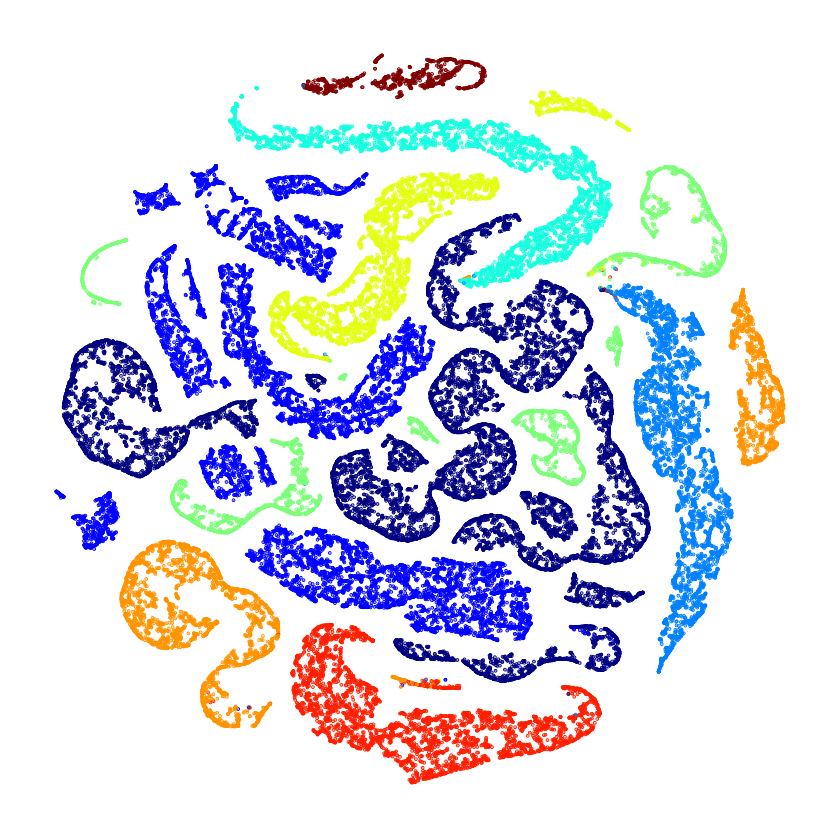

In [35]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(arch)
print(X_reduced.shape)
plot(X_reduced[:,0], X_reduced[:,1],targets1,args_img_filename+'_a_1.png')

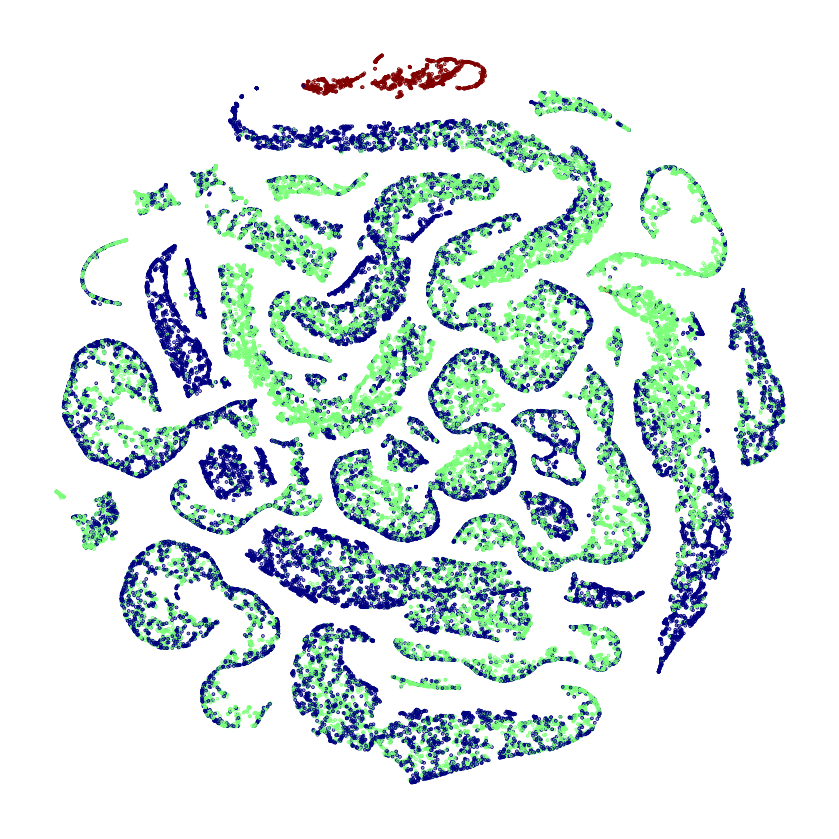

In [36]:
plot(X_reduced[:,0], X_reduced[:,1],targets2,args_img_filename+'_a_2.png')

/home/otsubo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/otsubo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(51000, 2)


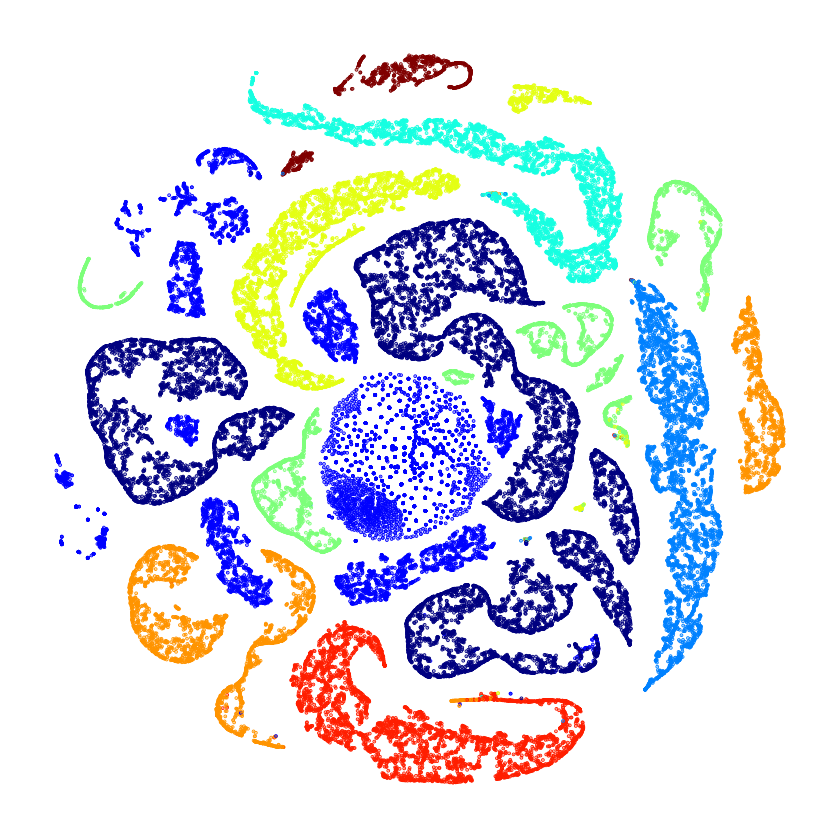

In [37]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(arch2)
print(X_reduced.shape)
plot(X_reduced[:,0], X_reduced[:,1],targets1,args_img_filename+'_a2_1.png')

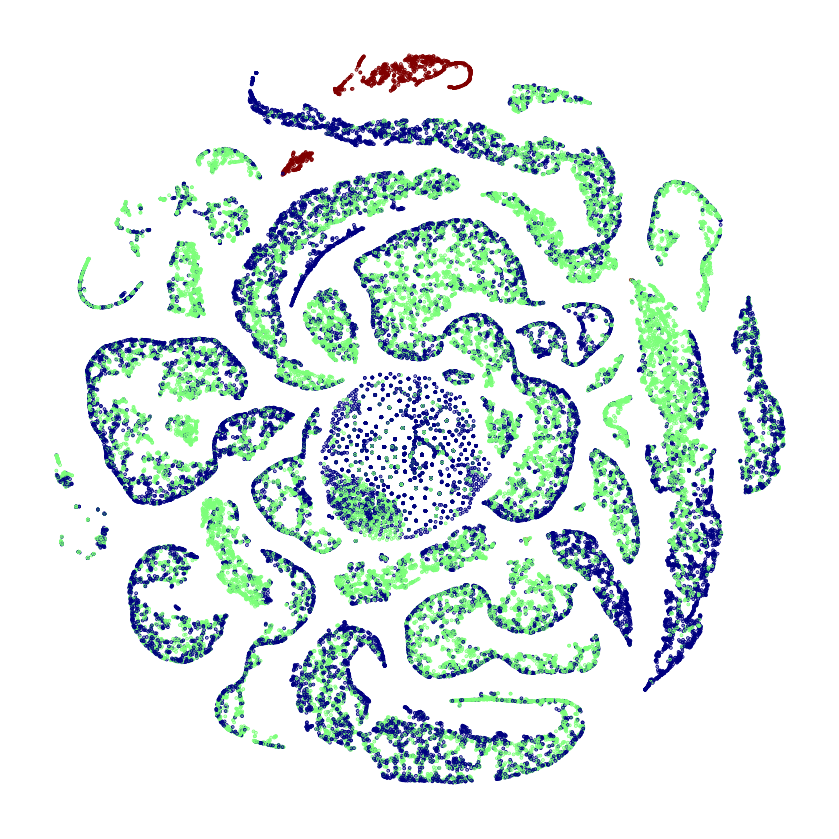

In [38]:
plot(X_reduced[:,0], X_reduced[:,1],targets2,args_img_filename+'_a2_2.png')

/home/otsubo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/otsubo/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(51000, 2)


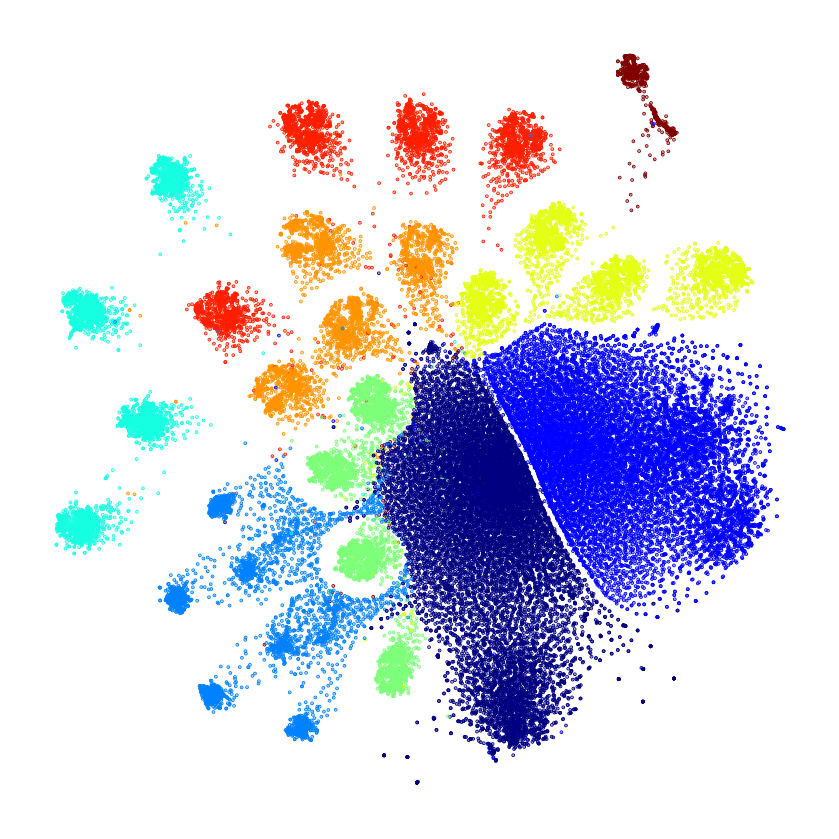

In [39]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(main_input)
print(X_reduced.shape)
plot(X_reduced[:,0], X_reduced[:,1],targets1,args_img_filename+'.png')

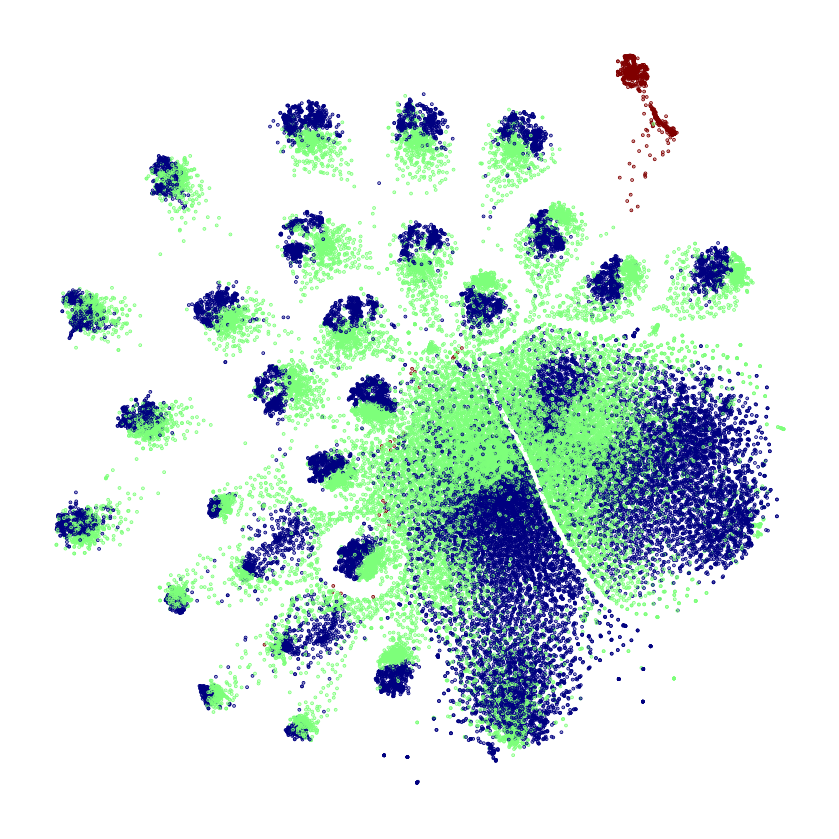

In [40]:
plot(X_reduced[:,0], X_reduced[:,1],targets2,args_img_filename+'_.png')

In [41]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap
from bokeh.io import output_notebook

# 出力設定
output_notebook()

mapper = linear_cmap(field_name="l", palette=Turbo256, low=min(targets), high=max(targets))
label = ["x86","x86-64","ARM","ARM64","MIPS","MIPS64","PowerPC","PowerPC64","Others"]
# 辞書
source = ColumnDataSource(data=dict(
    x=X_reduced[:,0],
    y=X_reduced[:,1],
    c=[label[i] for i in targets],
    l=targets,
))

# tooltips設定
TOOLTIPS = [
    ("index", "$index"),
    ("x", "$x"),
    ("y", "$y"), 
    ("label", "@c"),
]


# グラフ全体の設定
p = figure(
            title="test",
            plot_width=800,
            plot_height=600,
            x_axis_label='x', 
            y_axis_label='y',
            tooltips=TOOLTIPS
          )


# 描画
p.circle('x', 'y', color=mapper, fill_alpha=0.5, size=5, source=source)

# 出力
output_file("iris.html")
show(p)

Loading BokehJS ...